In [1]:
import numpy as np
import random
import os, sys
import warnings

from matplotlib import pyplot as plt

from env_variables import *
from lib.esn import ESN
from dataset.loading import DataLoader

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

data_path = '../../../'
dl = DataLoader(data_path)

dr = []
speakers = []
XorZ = "X"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10
const_params = {
    "n_mels":n_mels,
    "XorZ":XorZ,
    "N":100
}

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features_train, labels_train, _ = dl.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


In [2]:
from dataset.data_processing import *

phonemes, features_train, labels_train = filter_data(features_train, labels_train, limit=200)

Filtered to 7800 samples of shape (10, 14)


In [9]:
from lib.plotting.plot_0 import Plot
from experiments.helpers.experiment_helpers import *
from sklearn.base import BaseEstimator, ClassifierMixin

class Classifier(BaseEstimator, ClassifierMixin):

    def __init__(self,
                 W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights):
        self.W_in_scale = W_in_scale
        self.spectral_radius = spectral_radius
        self.b_scale = b_scale
        self.weights = weights

        self.n_mels = None
        self.XorZ = None
        self.N = None
        self.n_samples = None
        self.classes = None
        self.esn = None
        self.Cs_clas = None
        self.Ns_clas = None

    def fit(self, X, y, **params):
        self.n_mels = params["n_mels"]
        self.XorZ = params["XorZ"]
        self.N = params["N"]

        # Group data by class
        group = group_by_labels(X, y)

        self.classes = list(group.keys())
        self.n_samples = sum([len(x) for x in list(group.values())])

        print(f"Number of samples: {self.n_samples}")
        # Init Reservoir
        esn_params = {
            "in_dim": self.n_mels,
            "out_dim": self.n_mels,
            "N": self.N,
            "W_in_scale": self.W_in_scale,
            "b_scale": self.b_scale,
            "spectral_radius": self.spectral_radius,
            "weights": self.weights
        }
        self.esn = ESN(esn_params)

        Cs = []
        for _, signals in group.items():
            X = run_all(self.esn, signals, XorZ)
            Cs.append(compute_c(X, 1))
        ss_list = [ [sum_of_singular_vals(C)] for C in Cs ]
        Cs = optimize_apertures(Cs, start=0.5, end=500, n=150)

        #### Plotting

        target_sum = np.mean([sum_of_singular_vals(C) for C in Cs])
        #st = np.std([sum_of_singular_vals(C) for C in Cs])
        Cs, ss_list_2 = adapt_singular_vals_of_Cs(Cs, target_sum, debug=True)
        ss_list = [ ss_list[i] + ss_list_2[i] for i in range(len(ss_list)) ]
        #Ns = Ns_from_Cs(Cs)
        for ss in ss_list:
            plt.plot(ss)
        plt.show()
        # Return the classifier
        return self

    def predict(self, X):
        y = []
        for sample in X:
            x = self.esn.run(sample.T, XorZ=self.XorZ)
            es = evidences_for_Cs(x,self.Cs_clas,self.Ns_clas)
            if self.XorZ == "X":
                es = [ np.sum(p) for p in es ]
            y.append(self.classes[np.argmax(es)])

        return y

Number of samples: 7800
Computing gammas...
Optimal gamma:  235.60930948339322


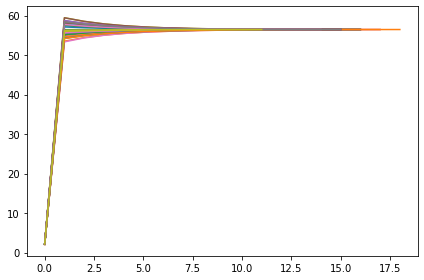

Classifier(W_in_scale=1.5, b_scale=0.2, spectral_radius=1.5, weights=0.1)

In [10]:
clas = Classifier(1.5,
    .2,
    1.5,
    .1)

clas.fit(features_train, labels_train, **{
    "n_mels": n_mels,
    "XorZ": "X",
    "N": 100
})